### First Heuristic - Preliminary implementation
#### Description

If a deposit address matches a withdraw address, then it is trivial to link the two addresses. Therefore, the deposit address needs to be removed from all the other withdraw addresses’ anonymity set. If a number $N$ of deposits with a same address $add1$, and a number $M$ ($M < N$) of withdraws with that same aaddress are detected, then a number $M - N$ of deposit transactions must be removed from the anonimity set of all the other withdraw transactions.

In [1]:
# Import relevant packages.
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
withdraw_transactions_df = pd.read_csv("../data/tornado_withdraw_df.csv")
withdraw_transactions_df["recipient_address"] = withdraw_transactions_df["recipient_address"].str.lower()
withdraw_transactions_df["block_timestamp"] = withdraw_transactions_df["block_timestamp"].apply(pd.Timestamp)

deposit_transactions_df = pd.read_csv("../data/deposit_transactions.csv")
deposit_transactions_df["block_timestamp"] = deposit_transactions_df["block_timestamp"].apply(pd.Timestamp)

### Function summary: same_deposit_and_recipient_addresses_heuristic

The function receives a particular withdraw transaction and the entire deposit transactions data.

It returns a tuple:

* (True, list_of_same_address_deposit_hashes): When same address deposits are found, this tuple is returned. In the first element a boolean true, and the second is a list with all the deposit hashes that verify having the same address as the withdraw transaction.

* (False, None): When no such deposit was found

In [1]:
def same_deposit_and_recipient_address_heuristic(withdraw_transaction, deposit_transactions_df):
    
    # Initialize empty array for storing deposit hashes that have the same address as the witdhraw.
    
    same_deposit_address_hashes = []
    
    # Iterate over each deposit transaction. When a matching deposit is found, its hash is pushed to
    # the list same_deposit_address_hashes.
    
    for deposit_row_tuple in deposit_transactions_df.itertuples():
        # Check that addresses are the same and that the deposit was done earlier than the withdraw.
        if (deposit_row_tuple.from_address == withdraw_transaction.recipient_address) and (deposit_row_tuple.block_timestamp < withdraw_transaction.block_timestamp):
            same_deposit_address_hashes.append(deposit_row_tuple.hash)
            
    # If the list is empty, return (False, None). Else, return (true, same_deposit_address_hashes)  
    if len(same_deposit_address_hashes) > 0:
        return (True, same_deposit_address_hashes)
    else:
        return (False, None)


### Function summary: apply_same_deposit_and_recipient_addresses_heuristic

Receives the withdraw and deposit transactions, and applies the first heuristic for each withdraw transaction. Returns a dictionary, with keys as the hash of each withdraw transaction were a same deposit address was detected. The values are the hashes of all deposits matching this criteria.


In [4]:
def apply_same_deposit_and_recpient_address_heuristic(withdraw_transactions_df, deposit_transactions_df):
    
    # Initialize an empty dictionary for storing the links between withdraw hashes and deposit hashes with the 
    # same address.
    
    same_deposit_address_hashes = {}
    
    # Iterate over the withdraw transactions and apply heuristic one. For each withdraw with matching deposit
    # transactions, a new element is added to the dictionary with the key as the withdraw hash and the values
    # as all matching deposit hashes.
    
    for withdraw_row_tuple in tqdm(withdraw_transactions_df.itertuples(), total=withdraw_transactions_df.shape[0], mininterval=15):
        deposit_hashes = same_deposit_and_recipient_address_heuristic(withdraw_row_tuple, deposit_transactions_df)
        if deposit_hashes[0]:
            same_deposit_address_hashes[withdraw_row_tuple.hash] = deposit_hashes[1]

    # Return the dictionary with the links
    
    return same_deposit_address_hashes

In [5]:
hashes_dict = apply_same_deposit_and_recpient_address_heuristic(withdraw_transactions_df, deposit_transactions_df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22009/22009 [40:36<00:00,  9.03it/s]


In [6]:
# Count of deposit transactions linked to withdraws.
linked_deposits_count = list(map(lambda x: len(x), hashes_dict.values()))

In [7]:
len(linked_deposits_count)

1430

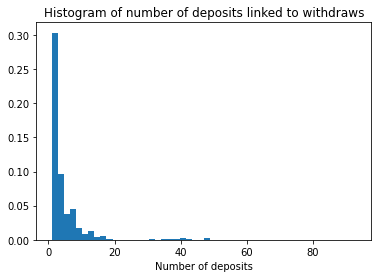

In [8]:
plt.hist(linked_deposits_count, bins=50, density=True)
plt.title("Histogram of number of deposits linked to withdraws")
plt.xlabel("Number of deposits")
plt.show()